In [1]:
import collections
import functools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
from scipy import special
from scipy import stats
import statsmodels.api as sm
from typing import Callable, NamedTuple, Tuple

In [2]:
LABELS = collections.OrderedDict([
    ('time', 'Time (weeks), $i$'),
    ('failures', 'Failures, $y_i$'),
    ('temperature', 'Temperature, $x_i$'),
])

failure_time_data = pd.DataFrame(collections.OrderedDict([
    ('time', ['${}$'.format(week) for week in range(1,13)] + ['$>12$']),
    ('failures', [210, 108, 58, 40, 17, 10, 7, 6, 5, 4, 2, 3, 15]),
    ('temperature', [24, 26, 24, 26, 25, 22, 23, 20, 21, 18, 17, 20, None]),
]))

with open('failure_time_data.tex', 'w') as f:
    f.write(
        pd.DataFrame(collections.OrderedDict(
            [(LABELS[i], value) for i, value in failure_time_data.items()])).to_latex(
            escape=False, index=False, na_rep=''))

failure_time_data

,time,failures,temperature
0,$1$,210,24.0
1,$2$,108,26.0
2,$3$,58,24.0
3,$4$,40,26.0
4,$5$,17,25.0
5,$6$,10,22.0
6,$7$,7,23.0
7,$8$,6,20.0
8,$9$,5,21.0
9,$10$,4,18.0


# Geometric Model

In [3]:
def score(y, p):
    y = np.asarray(y)
    N = len(y) - 1
    t = np.arange(1, len(y))
    return -N*y[-1]/(1-p) + np.sum(y[:-1]*(1/p - (t-1)/(1-p)))

def mle(y):
    y = np.asarray(y)
    return np.sum(y[:-1])/(y[-1]*(len(y) - 1) + np.sum(np.arange(1, len(y))*y[:-1]))

score(failure_time_data['failures'], mle(failure_time_data['failures']))
mle(failure_time_data['failures'])

0.35471698113207545

In [4]:
def fisher_information(y, p):
    N = len(y) - 1
    n = np.sum(y)
    return n*(1 - (1-p)**N)/(p*p*(1-p))

1/fisher_information(failure_time_data['failures'], mle(failure_time_data['failures']))

0.00016828364537217432

In [5]:
stats.norm.interval(
    0.95,
    loc=mle(failure_time_data['failures']),
    scale=np.sqrt(1/fisher_information(failure_time_data['failures'], mle(failure_time_data['failures']))))

(0.32929150780524236, 0.38014245445890854)

In [6]:
MU = 0.2
SIGMA = 0.08

def make_beta_shapes(mu, sigma):
    x = mu*(1-mu)/(sigma*sigma) - 1
    return mu*x, (1-mu)*x

PRIOR_ALPHA, PRIOR_BETA = make_beta_shapes(MU, SIGMA)
PRIOR_ALPHA, PRIOR_BETA

(4.800000000000001, 19.200000000000003)

In [7]:
def update_beta_shapes(prior_alpha, prior_beta, y):
    y = np.asarray(y)
    alpha = prior_alpha + np.sum(y[:-1])
    
    t = np.arange(1, len(y))
    N = len(y) - 1
    beta = prior_beta + np.sum((t-1)*y[:-1]) + y[-1]*N
    return alpha, beta 

ALPHA, BETA = update_beta_shapes(PRIOR_ALPHA, PRIOR_BETA, failure_time_data['failures'])
ALPHA, BETA 

(474.8, 874.2)

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


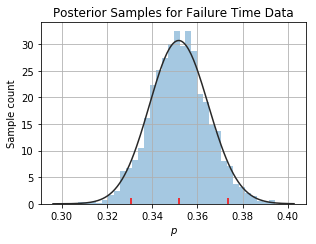

In [8]:
_PartialRvContinuous = NamedTuple(
    '_PartialRvContinuous', [
        ('pdf', Callable[[np.array], np.array]),
        ('fit', Callable[[np.array], Tuple[float, float]])])

np.random.seed(2018)
posterior_samples = stats.beta.rvs(a=ALPHA, b=BETA, size=2048)
#posterior_quantiles = np.quantile(posterior_samples, q=[0.05, 0.5, 0.95])
posterior_quantiles = stats.beta.ppf(q=[0.05, 0.5, 0.95], a=ALPHA, b=BETA)

fig = plt.figure(figsize=(4.5,3.5))
ax = fig.gca()
sns.distplot(posterior_samples, kde=False, ax=ax,
             fit=_PartialRvContinuous(pdf=stats.beta.pdf, fit=lambda _: (ALPHA, BETA)))
ax.vlines(posterior_quantiles, ymin=0, ymax=1, colors='r')
ax.grid(True)
ax.set_xlabel('$p$')
ax.set_ylabel('Sample count')
ax.set_title('Posterior Samples for Failure Time Data')
fig.tight_layout()
fig.savefig('p1_posterior_samples.pdf', bbox_inches='tight')

In [9]:
posterior_quantiles

array([0.33070873, 0.35189124, 0.37346975])

In [10]:
np.sqrt(np.var(stats.beta.rvs(4.8, 19.2, size=10000)))

0.0803034086438286

## Beta Hyperparameter

In [11]:
def score(y, alpha_beta):
    alpha, beta = alpha_beta
    y = np.asarray(y)
    n = np.sum(y)
    N = len(y) - 1
    t = np.arange(1, N + 1)
    
    acc = -n*(special.digamma(alpha) - special.digamma(alpha + beta))
    acc += y[-1]*(np.array([
        special.digamma(alpha),
        special.digamma(beta + N),
    ]) - special.digamma(alpha + beta + N))
    acc += np.sum(y[:-1]*(np.array([
        [special.digamma(alpha + 1)]*N,
        special.digamma(beta + t - 1),
    ]) - special.digamma(alpha + beta + t)), -1)
    return acc
    
optimize.root(functools.partial(score, failure_time_data['failures']), [1, 1])

    fjac: array([[-0.35881411, -0.93340904],
       [ 0.93340904, -0.35881411]])
     fun: array([3.03845127e-09, 6.03972694e-09])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.30196430e-07,  1.98313292e-08])
       r: array([ 534.93252681, -635.33824205,  -36.60794047])
  status: 1
 success: True
       x: array([1.413336  , 1.38001102])

## Binomial Model

In [12]:
def pearson_residuals(y, p):
    y = np.asarray(y)    
    nt = np.ones_like(y[:-1])*np.sum(y)
    nt[1:] -= np.cumsum(y)[:-2]
    mu = nt*p
    return (y[:-1] - mu)/np.sqrt(mu*(1-p))

residuals = pearson_residuals(failure_time_data['failures'], mle(failure_time_data['failures']))

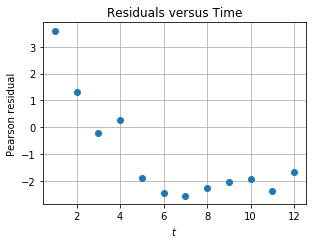

In [13]:
def plot_residuals(residuals, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(np.arange(len(residuals)) + 1, residuals, 'o')
    ax.grid(True)
    ax.set_ylabel('Pearson residual')
    ax.set_xlabel('$t$')
    
fig = plt.figure(figsize=(4.5, 3.5))
ax = fig.gca()
plot_residuals(residuals)
ax.set_title('Residuals versus Time')
fig.tight_layout()
fig.savefig('p3_residuals.pdf', bbox_inches='tight')

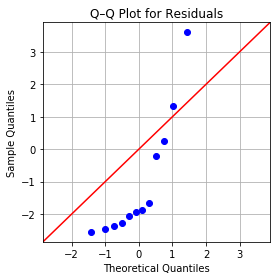

In [14]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
sm.qqplot(residuals, loc=0, scale=1, line='45', ax=ax, fit=False)
ax.grid(True)
ax.set_title('Q\u2013Q Plot for Residuals')
fig.tight_layout()
fig.savefig('p3_qq.pdf', bbox_inches='tight')

In [15]:
def score(y, beta):
    y = np.asarray(y)
    t = np.arange(1, len(y))
    nt = np.ones_like(y[:-1])*np.sum(y)
    nt[1:] -= np.cumsum(y)[:-2]    
    p = special.expit(beta[0] + beta[1]*t)
    mu = nt*p
    y = y[:-1]
    error = y-mu
    return np.sum(np.array([error, t*error]), axis=-1)

def observed_information(y, beta):
    y = np.asarray(y)
    t = np.arange(1, len(y))
    nt = np.ones_like(y[:-1])*np.sum(y)
    nt[1:] -= np.cumsum(y)[:-2]    
    p = special.expit(beta[0] + beta[1]*t)    
    X = np.column_stack((np.ones_like(t), t))
    return np.matmul(p*(1-p)*nt*X.T, X)

beta = optimize.root(
    functools.partial(score, failure_time_data['failures']), [0, 0],
    jac=lambda beta: -observed_information(failure_time_data['failures'], beta)).x
beta_standard_error = np.sqrt(
    np.diag(np.linalg.inv(observed_information(failure_time_data['failures'], beta))))

time_dependent_model_summary = pd.DataFrame(collections.OrderedDict([    
    ('MLE', beta),
    ('Standard error', beta_standard_error),
    ('95\% CI lower bound', beta + beta_standard_error*stats.norm.ppf(0.025)),
    ('95\% CI upper bound', beta + beta_standard_error*stats.norm.ppf(0.975)),
]), index=['$\\hat\\beta_0$', '$\\hat\\beta_1$'])

with open('p3_model_summary.tex', 'w') as f:
    f.write(time_dependent_model_summary.to_latex(escape=False))

time_dependent_model_summary

,MLE,Standard error,95\% CI lower bound,95\% CI upper bound
$\hat\beta_0$,-0.090505,0.091144,-0.269143,0.088133
$\hat\beta_1$,-0.174740,0.026138,-0.225969,-0.123511


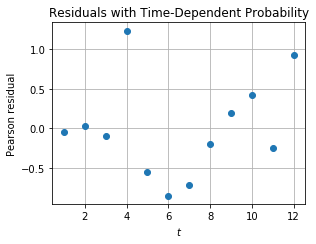

In [16]:
residuals = pearson_residuals(failure_time_data['failures'],
                              special.expit(beta[0] + beta[1]*np.arange(1, len(failure_time_data))))

fig = plt.figure(figsize=(4.5, 3.5))
ax = fig.gca()
plot_residuals(residuals)
ax.set_title('Residuals with Time-Dependent Probability')
fig.tight_layout()
fig.savefig('p3_residuals_time.pdf', bbox_inches='tight')

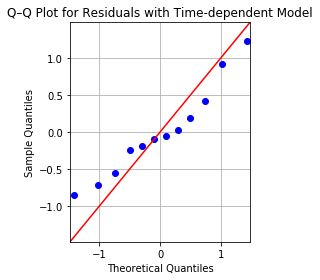

In [17]:
fig = plt.figure(figsize=(4, 4))
ax = fig.gca()
sm.qqplot(residuals, loc=0, scale=1, line='45', ax=ax, fit=False)
ax.grid(True)
ax.set_title('Q\u2013Q Plot for Residuals with Time-dependent Model')
fig.tight_layout()
fig.savefig('p3_qq_time.pdf', bbox_inches='tight')